# (PSL) Coding Assignment 3


Members:
* Amy Hwang (ahwang22)
* Monil Kaneria (kaneria2)
* Christian Tam (cmtam2)

Christian Tam completed part 1, Amy Hwang completed part 2, and Monil Kaneria completed part 3. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skmisc.loess import loess
import sklearn

import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from scipy.interpolate import splev

## Part I: Optimal span for LOESS

### Task 1: Retrieve the Diagonal of the Smoother Matrix

In [2]:
# Function to get diagonal of smoother matrix S
def get_smoother_matrix_diag(x, span):
    fake_y = np.zeros_like(x)
    loess_model = loess(x, fake_y, span=span)
    loess_model.fit()
    S_diag = loess_model.outputs.fitted_values 
    return S_diag

### Task 2: Write a function to find the Optimal Span(s) based on CV and GCV. 

In [3]:
# Function to calculate CV and GCV values
def calculate_cv_gcv(x, y, spans):
    n = len(x)
    loo = LeaveOneOut()
    cv_errors = []
    gcv_errors = []

    for span in spans:
        # Fit LOESS model for each span value
        loess_model = loess(x, y, span=span)
        loess_model.fit()
        y_pred = loess_model.outputs.fitted_values
        S_diag = get_smoother_matrix_diag(x, span)

        # Calculate CV error
        cv_error = 0
        for train_index, test_index in loo.split(x):
            x_train, x_test = x[train_index], x[test_index]
            y_train, y_test = y[train_index], y[test_index]
            loess_model.fit()
            y_pred_test = loess_model.outputs.fitted_values[test_index]
            cv_error += (y_test - y_pred_test) ** 2
        cv_error /= n
        cv_errors.append(cv_error)

        # Calculate GCV error
        gcv_error = np.sum((y - y_pred) ** 2) / (n * (1 - np.mean(S_diag)) ** 2)
        gcv_errors.append(gcv_error)

    return cv_errors, gcv_errors

### Task 3: Test code using Coding3_Data.csv.

Optimal span (CV): 0.2
Optimal span (GCV): 0.2


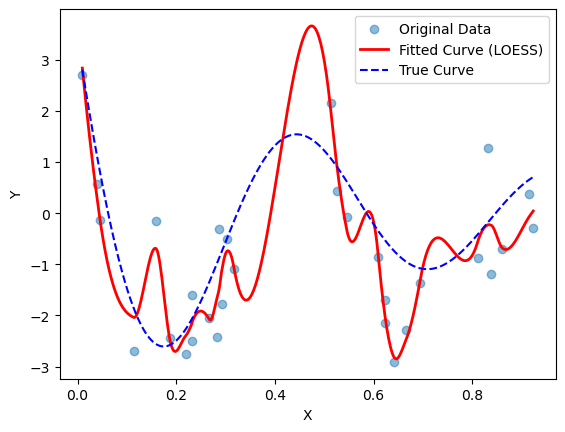

In [4]:
# Load the dataset
data = pd.read_csv("Coding3_Data.csv")
x = data['x'].values
y = data['y'].values

# Define span values
spans = np.linspace(0.20, 0.90, 15)

# Calculate CV and GCV
cv_errors, gcv_errors = calculate_cv_gcv(x, y, spans)

# Find the optimal span
optimal_span_cv = spans[np.argmin(cv_errors)]
optimal_span_gcv = spans[np.argmin(gcv_errors)]

print(f"Optimal span (CV): {optimal_span_cv}")
print(f"Optimal span (GCV): {optimal_span_gcv}")

# Fit LOESS model with optimal span
optimal_span = optimal_span_cv  # Both methods recommend the same span
loess_model = loess(x, y, span=optimal_span)
loess_model.fit()

# Create a finer grid for smoother curve
grid_x = np.linspace(x.min(), x.max(), 500)
y_pred = loess_model.predict(grid_x, stderror=True).values

# Plot the results
plt.scatter(x, y, label='Original Data', alpha=0.5)
plt.plot(grid_x, y_pred, color='red', label='Fitted Curve (LOESS)', linewidth=2)
plt.plot(grid_x, np.sin(12 * (grid_x + 0.2)) / (grid_x + 0.2), color='blue', label='True Curve', linestyle='--')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

## Part 2: Ridgeless and double descent

### Task 1: Ridgeless Function

In [5]:
def ridgeless(X_train, Y_train, X_test, Y_test):
    # Get the mean and standard deviation of each feature.
    X_train_mean = np.mean(X_train, axis=0)

    #Center Xtest
    X_train_center = X_train - X_train_mean
    X_test_center = X_test - X_train_mean
    
    #Get the intercept
    b0 = np.mean(Y_train, axis=0)

    # Perform SVD on Xtrain to get Xtrain = UDV^T
    U, S, Vh = np.linalg.svd(X_train_center)
    Vh = Vh.T
    
    # Identify the number of singular values greater than eps, denoted as k
    eps = 1e-10
    k = sum(S > eps)
    
    # Truncate V by selecting the first k columns, resulting in V_trunc. 
    V_trunc = Vh[:, 0:k]
    
    # Update the feature matrix as F = X_train*V_trunc.
    F = np.matmul(X_train_center, V_trunc)

    # Compute the LS coefficients associated with the design matrix F, denoted as alphahat = (F^T.F)^-1 x F^T x y_train.
    # This can be computed without matrix inversion as the matrix (F^T x F) is diagonal.
    Finv_train = np.diag(np.diag(F.T @ F)**-1)
    alphahat = np.matmul(np.matmul(Finv_train, F.T), Y_train)
    
    # Compute the prediction on the training data: Yhat_train = b0 + F x alphahat
    Yhat_train = b0 + np.matmul(F, alphahat)

    
    # Transform Xtest by multiplying it with V_trunc: F_test = X_test x V_trunc
    F_test = np.matmul(X_test_center, V_trunc)
    #Finv_test = np.diag(np.diag(F_test.T @ F_test)**-1)
    #alphahat_test = np.matmul(np.matmul(Finv_test, F_test.T), Y_train)
    
    # Similarly, compute the prediction on the test data.
    Yhat_test = b0 + np.matmul(F_test, alphahat)

    # Calculate and return the train/test Mean Squared Prediction Errors
    mse_test = mean_squared_error(Y_test, Yhat_test)
    mse_train = mean_squared_error(Y_train, Yhat_train)

    return mse_train, mse_test

### Task 2: Simulation Study

In [6]:
np.random.seed(4999)

In [7]:
myData = pd.read_csv("Coding3_DataH.csv", header=None)

Y = myData.iloc[:, 0]
X = myData.drop(myData.columns[0],axis=1)

In [8]:
test_error = np.zeros((30, 236))

for i in range(30):
    # Splitting the data into 25% training and 75% testing sets
    n = len(Y)
    indices = np.arange(0, n)
    np.random.shuffle(indices)
    
    train_ind = indices[:int(np.floor(0.25*n))]
    test_ind = indices[len(train_ind):]
    
    X_train = X.iloc[train_ind]
    Y_train = Y[train_ind]
    X_test = X.iloc[test_ind]
    Y_test = Y[test_ind]

    for d in range(6, 241):
        mse_train, mse_test = ridgeless(X_train.iloc[:, 0:d], Y_train, X_test.iloc[:, 0:d], Y_test)
        test_error[i, d-6] = mse_test


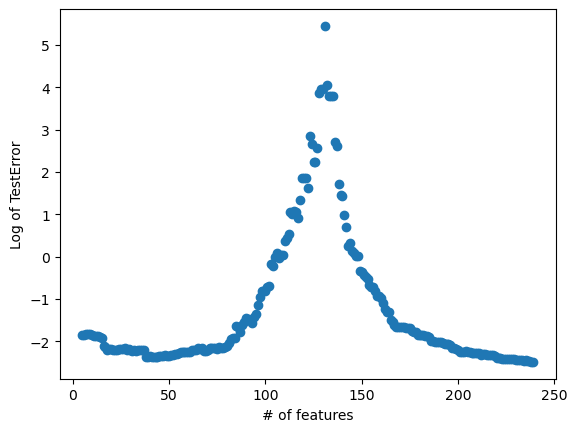

In [9]:
test_error_log_median = np.log(np.median(test_error,axis=0))
x_range = [range(5, 241)]

plt.scatter(x_range, test_error_log_median)
plt.ylabel("Log of TestError")
plt.xlabel("# of features")
plt.show()

## Part III: Clustering time series

In [10]:
url = "https://raw.githubusercontent.com/liangfgithub/liangfgithub.github.io/master/Data/Sales_Transactions_Dataset_Weekly.csv"
data = pd.read_csv(url).iloc[:, 1:53].values
mean = np.mean(data, axis=1, keepdims=True)
X_centered = data - mean
print(X_centered.shape)

(811, 52)


### Task 1: Fitting NCS

In [11]:
# converted from R's ns()
def ns(x, df=None, knots=None, boundary_knots=None, include_intercept=False):
    degree = 3
    
    if boundary_knots is None:
        boundary_knots = [np.min(x), np.max(x)]
    else:
        boundary_knots = np.sort(boundary_knots).tolist()

    oleft = x < boundary_knots[0]
    oright = x > boundary_knots[1]
    outside = oleft | oright
    inside = ~outside

    if df is not None:
        nIknots = df - 1 - include_intercept
        if nIknots < 0:
            nIknots = 0
            
        if nIknots > 0:
            knots = np.linspace(0, 1, num=nIknots + 2)[1:-1]
            knots = np.quantile(x[~outside], knots)

    Aknots = np.sort(np.concatenate((boundary_knots * 4, knots)))
    n_bases = len(Aknots) - (degree + 1)

    if any(outside):
        basis = np.empty((x.shape[0], n_bases), dtype=float)
        e = 1 / 4 # in theory anything in (0, 1); was (implicitly) 0 in R <= 3.2.2

        if any(oleft):
            k_pivot = boundary_knots[0]
            xl = x[oleft] - k_pivot
            xl = np.c_[np.ones(xl.shape[0]), xl]

            # equivalent to splineDesign(Aknots, rep(k.pivot, ord), ord, derivs)
            tt = np.empty((xl.shape[1], n_bases), dtype=float)
            for j in range(xl.shape[1]):
                for i in range(n_bases):
                    coefs = np.zeros((n_bases,))
                    coefs[i] = 1
                    tt[j, i] = splev(k_pivot, (Aknots, coefs, degree), der=j)

            basis[oleft, :] = xl @ tt

        if any(oright):
            k_pivot = boundary_knots[1]
            xr = x[oright] - k_pivot
            xr = np.c_[np.ones(xr.shape[0]), xr]

            tt = np.empty((xr.shape[1], n_bases), dtype=float)
            for j in range(xr.shape[1]):
                for i in range(n_bases):
                    coefs = np.zeros((n_bases,))
                    coefs[i] = 1
                    tt[j, i] = splev(k_pivot, (Aknots, coefs, degree), der=j)
                    
            basis[oright, :] = xr @ tt
        
        if any(inside):
            xi = x[inside]
            tt = np.empty((len(xi), n_bases), dtype=float)
            for i in range(n_bases):
                coefs = np.zeros((n_bases,))
                coefs[i] = 1
                tt[:, i] = splev(xi, (Aknots, coefs, degree))

            basis[inside, :] = tt
    else:
        basis = np.empty((x.shape[0], n_bases), dtype=float)
        for i in range(n_bases):
            coefs = np.zeros((n_bases,))
            coefs[i] = 1
            basis[:, i] = splev(x, (Aknots, coefs, degree))

    const = np.empty((2, n_bases), dtype=float)
    for i in range(n_bases):
        coefs = np.zeros((n_bases,))
        coefs[i] = 1
        const[:, i] = splev(boundary_knots, (Aknots, coefs, degree), der=2)

    if include_intercept is False:
        basis = basis[:, 1:]
        const = const[:, 1:]

    qr_const = np.linalg.qr(const.T, mode='complete')[0]
    basis = (qr_const.T @ basis.T).T[:, 2:]

    return basis

### Task 2: Cluster Matrix B

In [12]:
weeks = np.arange(1, 53, 1)
F = ns(weeks, df=10)
F_mean = F.mean(axis=0)
F_centered = F - F_mean
BT = np.linalg.inv(F_centered.T @ F_centered) @ F_centered.T @ X_centered.T
B = BT.T

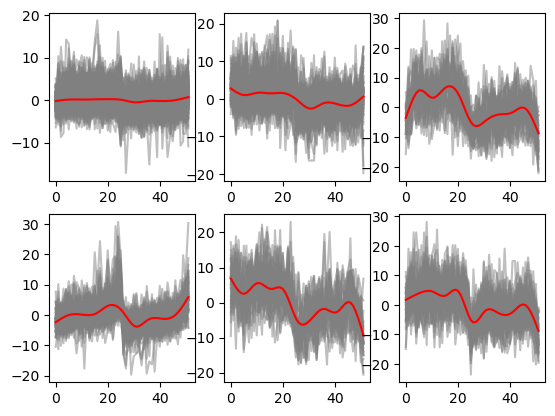

In [13]:
k = 6
kmeans_B = KMeans(n_clusters=k).fit(B)
labels_B = kmeans_B.labels_
cluster_centers_B = kmeans_B.cluster_centers_

fig, axes = plt.subplots(2, 3)
axes = axes.ravel()

for idx in range(k):
    cluster_idx = np.where(labels_B == idx)[0]
    centered_timeseries = X_centered[cluster_idx, :]

    for timeseries in centered_timeseries:
        axes[idx].plot(timeseries, color='grey', alpha=0.5)

    cluster_center = F_centered @ cluster_centers_B[idx]
    axes[idx].plot(cluster_center, color='red')

plt.show()

### Task 3: Cluster Matrix X

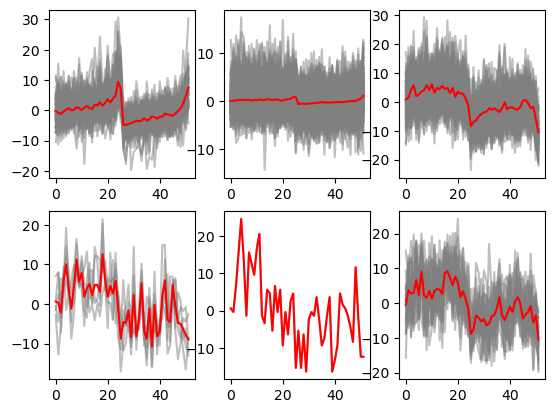

In [14]:
k = 6
kmeans_X = KMeans(n_clusters=k).fit(X_centered)
labels_X = kmeans_X.labels_
cluster_centers_X = kmeans_X.cluster_centers_

fig, axes = plt.subplots(2, 3)
axes = axes.ravel()

for idx in range(k):
    cluster_idx = np.where(labels_X == idx)[0]
    centered_timeseries = X_centered[cluster_idx, :]

    for timeseries in centered_timeseries:
        axes[idx].plot(timeseries, color='grey', alpha=0.5)

    cluster_center = cluster_centers_X[idx]
    axes[idx].plot(cluster_centers_X[idx], color='red')

plt.show()